## Ordinary Differential Equations 

Following https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/ 

## Create functions 

To create a function, just do the following: 

In [1]:
function add(x,y) 
    return x + y 
end 

add (generic function with 1 method)

Now use the function: 

In [2]:
add(1,2) 

3

## Now let's make a plot 

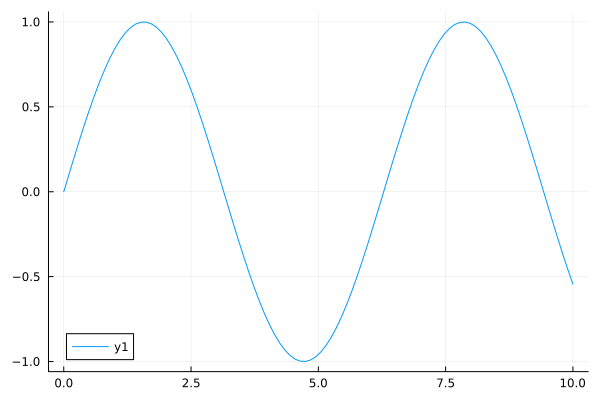

In [3]:
using Plots 

x = range(0, 10, length=100) 
y = sin.(x) 
plot(x,y) 

## Differential Equations 

Solve scalar equations: 

$$ \frac{du}{dt} = f(u, p, t) $$ 

on time interval $ t \in [0, 1] $ where: 

$$ f(u, p, t) = \alpha u $$  

Thus: 

$$ \frac{du}{dt} = \alpha u $$ 



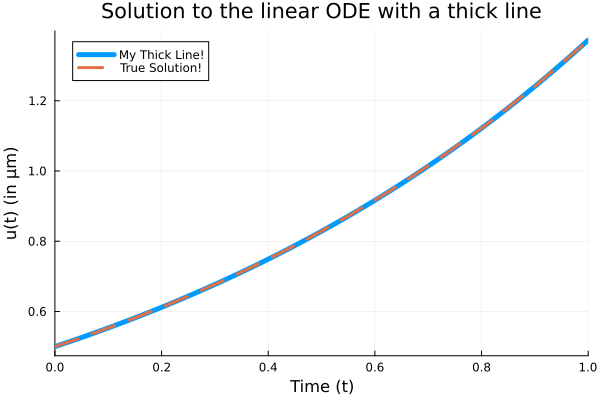

In [4]:
using DifferentialEquations

f(u,p,t) = 1.01*u ; 
u0       = 1/2 ; 
tspan    = (0.0,1.0) ; 
prob     = ODEProblem(f, u0, tspan) ; 
sol      = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8) ; 

using Plots
plot(sol, 
     linewidth = 5, 
     title ="Solution to the linear ODE with a thick line",
     xaxis = "Time (t)", 
     yaxis = "u(t) (in μm)", 
     label = "My Thick Line!") # legend=false
plot!(sol.t, 
     t->0.5*exp(1.01t), 
     lw = 3, 
     ls = :dash, 
     label = "True Solution!")

In `DifferentialEquations.jl`, some good "go-to" choices for ODEs are:

- AutoTsit5(Rosenbrock23()) handles both stiff and non-stiff equations. This is a good algorithm to use if you know nothing about the equation.
- AutoVern7(Rodas5()) handles both stiff and non-stiff equations in a way that's efficient for high accuracy.
- **Tsit5() for standard non-stiff. This is the first algorithm to try in most cases.**
- BS3() for fast low accuracy non-stiff.
- Vern7() for high accuracy non-stiff.
- Rodas4() or Rodas5() for small stiff equations with Julia-defined types, events, etc.
- KenCarp4() or TRBDF2() for medium sized (100-2000 ODEs) stiff equations
- RadauIIA5() for really high accuracy stiff equations
- QNDF() for large stiff equations

## Solving Systems of Equations 

In this example we will use the Lorenz equations: 

\begin{align} 
\frac{dx}{dt} &=  \sigma (y - x)  \\ 
\frac{dy}{dt} &=  x (\rho - z) - y \\ 
\frac{dz}{dt} &= xy - \beta z 
\end{align}

ODE functions in Julia can be updated "in-place" which can have performance benefits. Instead of writing a function that outputs its solution, write a function that updates a vector which is assigned to the solution. This allows DifferentialEquations.jl to reduce the amount of array allocations and achieve better performance. 

To do this, write the output as the 1st input of the function. For example: 



In [5]:
function lorenz(du, u, p, t)

    du[1] = 10.0 * ( u[2] - u[1] )
    du[2] = u[1] * ( 28.0 - u[3] ) - u[2] 
    du[3] = u[1]*u[2] - (8/3) * u[3]  

end 

lorenz (generic function with 1 method)

Now use the function in a problem: 

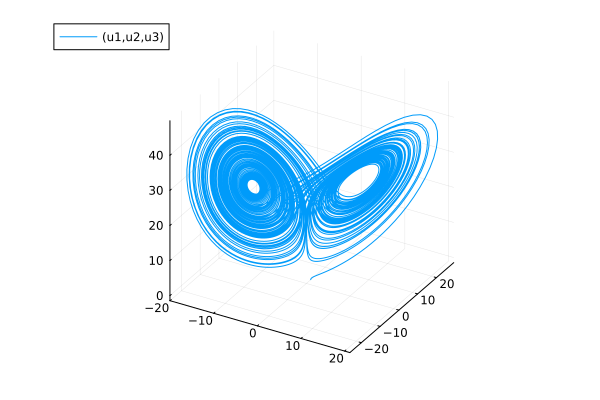

In [6]:
# ICs and tspan 
u0 = [ 1.0; 0.0; 0.0 ] ; 
ts = (0.0, 100.0) ; 

# the arguments to ODEProblem are : (function, IC, timespan)
prob = ODEProblem(lorenz, u0, ts) ; 
sol  = solve(prob) ; 

# plot 
plot( sol, idxs = (1,2,3) )

To parameterize the functions, use the p values via the syntax: 

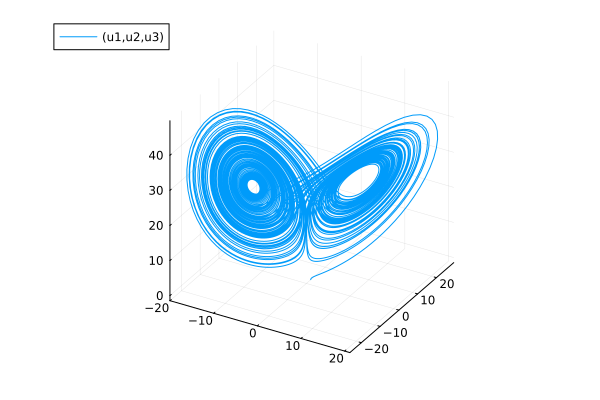

In [7]:
# define the function 
function lorenz(du, u, p, t)

    du[1] = p[1] * ( u[2] - u[1] )
    du[2] = u[1] * ( p[2] - u[3] ) - u[2] 
    du[3] = u[1]*u[2] - p[3] * u[3]  

end 

# ICs, tspan, and parameters 
u0 = [ 1.0; 0.0; 0.0 ] ; 
ts = (0.0, 100.0) ; 
p  = [10.0, 28.0, 8/3] ; 

# the arguments to ODEProblem are : (function, IC, timespan, parameters)
prob = ODEProblem(lorenz, u0, ts, p) ; 
sol  = solve(prob) ; 

# plot 
plot( sol, idxs = (1,2,3) )

Unicode characters can also be assigned to variables, which makes equations look a lot nicer. Recall the symbolic form of the Lorenz equations: 

\begin{align} 
\frac{dx}{dt} &=  \sigma (y - x)  \\ 
\frac{dy}{dt} &=  x (\rho - z) - y \\ 
\frac{dz}{dt} &= xy - \beta z 
\end{align}



In [8]:
# define function 
function lorenz(du, u, p, t)

    x,y,z = u 
    σ,ρ,β = p 
    du[1] = dx = σ * ( y - x )
    du[2] = dy = x * ( ρ - z ) - y 
    du[3] = dz = x * y - β * z  

end 

lorenz (generic function with 1 method)

## Nonhomogeneous Equations 

Nonhomogeneous ODEs can also be parameterized in Julia. They are frequently used as models for dynamical systems with external (generally time-varying) inputs. For example, consider a model of a pendulum with a slender rod of length $l$ and mass $m$: 

\begin{align} 
    \frac{d\theta(t)}{dt} &= w(t) \\ 
    \frac{d\omega(t)}{dt} &= - \frac{3}{2} \frac{g}{l} sin \theta(t) + \frac{3}{ml^2}M(t)
\end{align} 

where $\theta$ is the angular deviation of the pendulum from the vertical (hanging) orientation and $\omega$ is the angular rate.  

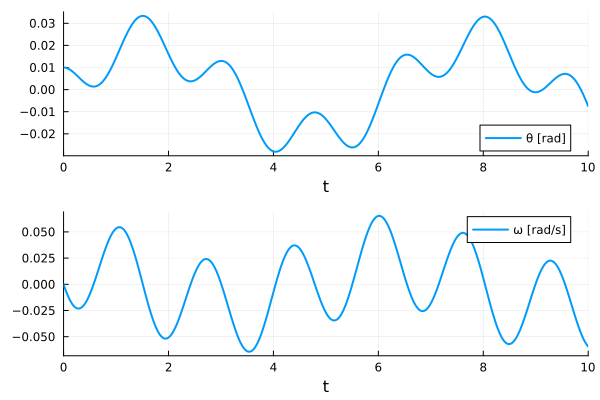

In [9]:
using DifferentialEquations
using Plots

l = 1.0                             # length [m]
m = 1.0                             # mass [kg]
g = 9.81                            # gravitational acceleration [m/s²]

function pendulum!(du,u,p,t)
    du[1] = u[2]                    # θ'(t) = ω(t) 
    du[2] = -3g/(2l)*sin(u[1]) + 3/(m*l^2)*p(t) # ω'(t) = -3g/(2l) sin θ(t) + 3/(ml^2)M(t)
end

θ₀ = 0.01                           # initial angular deflection [rad]
ω₀ = 0.0                            # initial angular velocity [rad/s]
u₀ = [θ₀, ω₀]                       # initial state vector
tspan = (0.0,10.0)                  # time interval

M = t->0.1sin(t)                    # external torque [Nm]

prob = ODEProblem(pendulum!,u₀,tspan,M)
sol = solve(prob)

plot(sol,linewidth=2,xaxis="t",label=["θ [rad]" "ω [rad/s]"],layout=(2,1))

## Other Types of Systems of Equations (like Matrices)  

Let u be a matrix! 

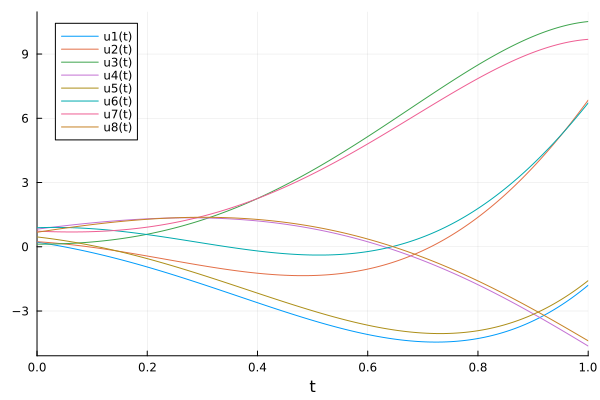

In [10]:
# matrix 
A  = [1. 0  0 -5
      4 -2  4 -3
     -4  0  0  1
      5 -2  2  3]

# IC and tspan 
u0 = rand(4,2)
tspan = (0.0,1.0)

# ODE 
f(u,p,t) = A*u
prob = ODEProblem(f,u0,tspan)

# solve and plot 
sol = solve(prob) 
plot(sol) 

We  can also use the in-place form with Julia's matrix multiplication function `mul!` :


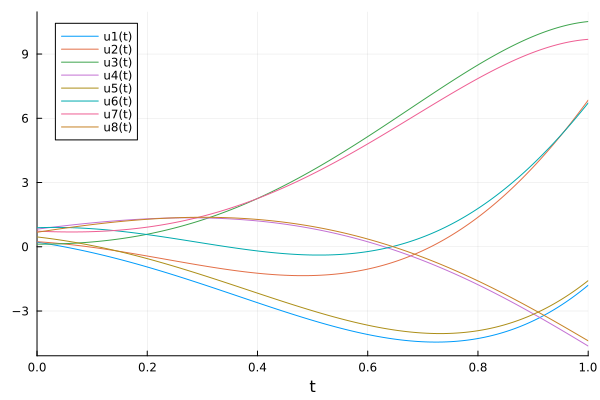

In [11]:
using LinearAlgebra

# ODE 
f(du,u,p,t) = mul!(du, A, u) 
prob = ODEProblem(f,u0,tspan)

# solve and plot 
sol = solve(prob) 
plot(sol) 

`StaticArrays.jl` offers stack-allocated arrays, which means their usage does not require any (slow) heap-allocations. Variables used for computation must also be initialized to the same data type. 

In [48]:
using StaticArrrays, DifferentialEquations

# define 
A  = @SMatrix [  1.0  0.0  0.0 -5.0
                 4.0 -2.0  4.0 -3.0 
                -4.0  0.0  0.0  1.0 
                 5.0 -2.0  2.0  3.0 ] 
u0 = @SMatrix rand(4,2) 
ts = (0.0, 1.0) 

# ODE function 
f(u,p,t) = A*u 
prob = ODEProblem(f, u0, ts) 
sol  = solve(prob) 

# plot 
using Plots 
plot(sol) 


ArgumentError: ArgumentError: Package StaticArrrays not found in current path.
- Run `import Pkg; Pkg.add("StaticArrrays")` to install the StaticArrrays package.